In [757]:
import pandas as pd
import numpy as np
from scipy import stats
from utils import generate_data
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
plt.rcParams["figure.figsize"] = (12,6)
import warnings
from timeit import default_timer as timer

In [1004]:
data = generate_data()

In [1005]:
data.x_df.head()
# days since start is z normalized

,intercept,days_since_start,days_since_start_squared,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,seasonality_cos,seasonality_sin
0,1.0,-1.729679,2.228932,0,0,0,0,0,1,0.999852,0.017213
1,1.0,-1.726517,2.216707,0,0,0,0,0,0,0.999407,0.034422
2,1.0,-1.723355,2.204505,1,0,0,0,0,0,0.998667,0.051620
3,1.0,-1.720193,2.192325,0,1,0,0,0,0,0.997630,0.068802
4,1.0,-1.717031,2.180168,0,0,1,0,0,0,0.996298,0.085965


In [1006]:
gpois_mdl = sm.GeneralizedPoisson(data.y, data.x_df)
gpois_res = gpois_mdl.fit(method="ncg")

Optimization terminated successfully.
         Current function value: 6.033271
         Iterations: 8
         Function evaluations: 8
         Gradient evaluations: 8
         Hessian evaluations: 8


In [1007]:
gpois_res.params

intercept                   5.230094
days_since_start            0.344392
days_since_start_squared   -0.140781
day_of_week_1               0.264007
day_of_week_2               0.278536
day_of_week_3               0.312065
day_of_week_4               0.299049
day_of_week_5               0.207650
day_of_week_6               0.036174
seasonality_cos             0.116133
seasonality_sin            -0.074277
alpha                       7.215118
dtype: float64

In [1008]:
print(gpois_res.summary2())

                       Results: GeneralizedPoisson
Model:                 GeneralizedPoisson  Pseudo R-squared:  0.049      
Dependent Variable:    y                   AIC:               13236.8638 
Date:                  2022-04-03 16:11    BIC:               13296.8459 
No. Observations:      1095                Log-Likelihood:    -6606.4    
Df Model:              10                  LL-Null:           -6949.3    
Df Residuals:          1084                LLR p-value:       7.2941e-141
Converged:             1.0000              Scale:             1.0000     
-------------------------------------------------------------------------
                          Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------
intercept                 5.2301   0.0394 132.6859 0.0000  5.1528  5.3073
days_since_start          0.3444   0.0149  23.0699 0.0000  0.3151  0.3737
days_since_start_squared -0.1408   0.0140 -10.0329 0.0000 -0.

In [1009]:
# Marginal effects
me = gpois_res.get_margeff(method='dydx')
me.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
 GeneralizedPoisson Marginal Effects 
=====================================
Dep. Variable:                      y
Method:                          dydx
At:                           overall
============================================================================================
                              dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
days_since_start            84.7227      3.910     21.670      0.000      77.060      92.385
days_since_start_squared   -34.6330      3.495     -9.909      0.000     -41.483     -27.783
day_of_week_1               64.9475     12.645      5.136      0.000      40.164      89.731
day_of_week_2               68.5216     12.679      5.404      0.000      43.671      93.372
day_of_week_3               76.7701     12.605      6.090      0.000      52.064     101.476
day_of_week_4               73.5680     12.656      5.813      0.000      48.762      98.374
day_of_week_5               51.0833     12.755      4.005      0.000      26.083      76.083
day_of_week_6                8.8990     13.039      0.683      0.495     -16.656      34.454
seasonality_cos             28.5694      4.689      6.092      0.000      19.378      37.760
seasonality_sin            -18.2726      4.829     -3.784      0.000     -27.737      -8.809
============================================================================================
"""

## Extend Generic Likelihood Model

In [1321]:
eps = 0. #to fix log(0) error
def _ll_latentnorm(y, X, beta, alph):
    mu = (np.dot(X, beta)) # Should we exponentiate this??
    sigma = np.exp(np.dot(X, alph))
    Phi_bar = stats.norm(mu, sigma).cdf(np.log1p(y))
    Phi_underbar = stats.norm(mu, sigma).cdf(np.log(y))
    ll = np.log(Phi_bar - Phi_underbar + eps)
    #print(Phi_bar - Phi_underbar)
    return ll

def _gradutils(y, X, beta, alph):
    mu = (np.dot(X, beta)) # Should we exponentiate this??
    sigma = np.exp(np.dot(X, alph))

    z_bar = (np.log1p(y) - mu) / sigma 
    z_underbar = (np.log(y) - mu) / sigma

    Phi_bar = stats.norm.cdf(z_bar)
    Phi_underbar = stats.norm.cdf(z_underbar)
    Phi  = Phi_bar - Phi_underbar + eps #small tolerance to fix div/zero error

    phi_bar = stats.norm.pdf(z_bar)
    phi_underbar = stats.norm.pdf(z_underbar)
    phi = phi_bar - phi_underbar + eps #small tolerance
    
    kappa_0 = phi / Phi
    kappa_1 = (z_bar * phi_bar - z_underbar * phi_underbar) / Phi
    kappa_2 = (z_bar**2 * phi_bar - z_underbar**2 * phi_underbar) / Phi
    kappa_3 = (z_bar**3 * phi_bar - z_underbar**3 * phi_underbar) / Phi
    
    return kappa_0, kappa_1, kappa_2, kappa_3, mu, sigma
    
def _vec_matrix_multiply(a, B):
    return np.apply_along_axis(lambda x: x * a, 0, B)

In [1322]:
class MyLatentNormal(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(MyLatentNormal, self).__init__(endog, exog, **kwds)
        self.nparams = 22
        
    def nloglikeobs(self, params):
        exog = self.exog
        endog = self.endog
        beta = params[:11] #first 11 are for mu
        alph = params[11:] #last 11 are for sigma
        ll = _ll_latentnorm(endog, exog, beta, alph)
        params_alt = params.copy()
        params_alt[0] = 0.
#         params_alt[11] = 0.
        return -ll - self.penalty*np.sum(params_alt**2)/self.endog.size
    
    def score(self, params):
        y = self.endog
        X = self.exog
        beta = params[:11] #first 11 are for mu
        alph = params[11:] #last 11 are for sigma
        
        kappa_0, kappa_1, kappa_2, kappa_3, mu, sigma = _gradutils(y, X, beta, alph)
        
        beta_alt = beta.copy()
        beta_alt[0] = 0
        alph_alt = alph.copy()
#         alph_alt[0] = 0.
        
        grad_beta = -(kappa_0 / sigma) @ X - penalty*2 * beta_alt
        grad_alph = -kappa_1 @ X - self.penalty*2 * alph_alt
        
        return np.append(grad_beta, grad_alph)
    
    def hessian(self, params):
        y = self.endog
        X = self.exog
        beta = params[:11] #first 11 are for mu
        alph = params[11:] #last 11 are for sigma
        
        kappa_0, kappa_1, kappa_2, kappa_3, mu, sigma = _gradutils(y, X, beta, alph)
        
        #xx = np.einsum('ij,ij-> i', X, X) # row-wise dot product?
        k_beta = (kappa_0**2 + kappa_1) / sigma**2
        k_alph = kappa_1 * (kappa_1 - 1) + kappa_3
        k_beta_alph = (kappa_2 + kappa_0*(kappa_1 - 1)) / sigma
        H_beta = np.zeros([11, 11])
        H_alph = np.zeros([11, 11])
        H_beta_alph = np.zeros([11, 11])
                  
        for i in range(X.shape[0]):
            x = X[i]
            xxT = np.outer(x, x)
            H_beta -= k_beta[i] * xxT
            H_alph -= k_alph[i] * xxT
            H_beta_alph -= k_beta_alph[i] * xxT
        
        H_all = np.block([[H_beta, H_beta_alph], [H_beta_alph.T, H_alph]]) # 22 x 22
        penalty_matrix = self.penalty*2 * np.eye(22)
        penalty_matrix[0, 0] = 0.
#         penalty_matrix[11, 11] = 0.

        return H_all - penalty_matrix
    
    def predict(self, params, exog=None, n=1000):
        if exog is None:
            X = self.exog
        beta = params[:11] #first 11 are for mu
        alph = params[11:] #last 11 are for sigma
        mu = (np.dot(X, beta))
        sigma = np.exp(np.dot(X, alph))
        Z = stats.norm(mu,sigma).rvs(size = (n, self.endog.size)) # n random realizations. Could find closed form..
        Y_hat = np.floor(np.exp(Z)).mean(axis=0)
        return Y_hat
    
    def mse(self):
        r = self.endog - self.predict()
        return np.mean(r**2)
        
    
    def fit(self, start_params=None, maxiter=10000, maxfun=5000, penalty=0., **kwds):
        self.penalty = penalty
        #print(self.penalty)
        if start_params is None:
            # Reasonable starting values
            start_params = np.zeros(self.nparams)
            start_params[0] = np.log(np.mean(self.endog)) # beta
        return super(MyLatentNormal, self).fit(start_params=start_params,
                                     maxiter=maxiter, maxfun=maxfun,
                                     **kwds)
    

def fittedmean(res):
    return pd.Series(res.exog @ res.params[:11])

def fittedvar(res):
    return pd.Series(np.exp(res.exog @ res.params[11:]))

def mse(res, y):
    r = y - res.predict()
    return np.mean(r**2)

In [1305]:
names = list(data.x_df)
names_alpha = [s + "_alpha" for s in names]

In [1351]:
np.seterr(divide = 'warn')
np.seterr(invalid= 'warn')

start_params = 0.001 * np.ones(22)
start_params[:11] = pois_res.params[:11]
mod = MyLatentNormal(data.y, data.x_df, extra_params_names=names_alpha)

mod_res = mod.fit(method = "bfgs", start_params = start_params, maxiter=100, penalty=1e-4)
print(mod_res.summary())
print(f"True Beta: {data.beta}")
print(f"True Alpha: {data.alpha}")

Optimization terminated successfully.
         Current function value: 5.929070
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
                            MyLatentNormal Results                            
Dep. Variable:                      y   Log-Likelihood:                -6492.3
Model:                 MyLatentNormal   AIC:                         1.301e+04
Method:            Maximum Likelihood   BIC:                         1.306e+04
Date:                Sun, 03 Apr 2022                                         
Time:                        22:28:09                                         
No. Observations:                1095                                         
Df Residuals:                    1084                                         
Df Model:                          10                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------

In [1344]:
mod_res.mle_retvals

{'fopt': 5.929069998605852,
 'gopt': array([-3.59773069e-06, -1.97211764e-06,  6.38470869e-06,  1.21454442e-06,
         7.70732967e-06, -9.15378514e-06, -7.79054606e-07,  1.69549368e-06,
         1.79409505e-06,  9.71402406e-07, -4.46631943e-07, -9.07338561e-07,
        -2.72059224e-06, -8.61564524e-09, -8.59711676e-08, -3.34557194e-07,
        -1.03728790e-06, -2.08250008e-06,  1.76860102e-06, -2.25983371e-08,
         4.85804689e-07,  2.29868017e-06]),
 'Hinv': array([[ 9.02319705e-01, -1.06448689e-01,  1.24047322e-02,
         -8.93790604e-01, -8.06042376e-01, -8.93762675e-01,
         -8.65057866e-01, -8.40626498e-01, -8.39056223e-01,
          3.81087942e-02, -1.73249245e-02,  9.89804327e-02,
         -5.84544855e-02, -1.31793800e-02, -8.53770408e-02,
         -1.04647004e-01, -1.09478540e-01, -1.08481131e-01,
         -6.40734689e-02, -6.65915933e-02,  8.82371066e-05,
          7.88685204e-02],
        [-1.06448689e-01,  2.61685305e-01, -6.37865121e-02,
          7.60718215e-03,

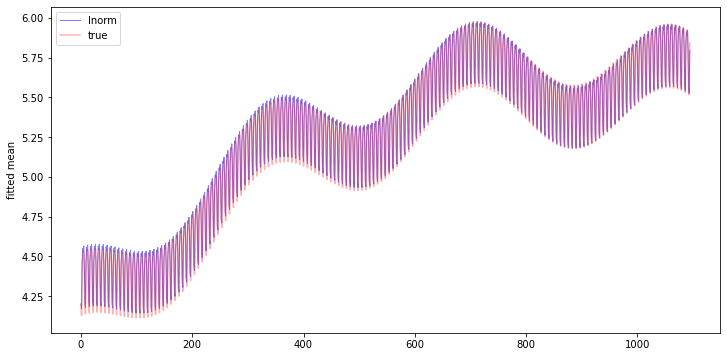

In [1345]:
fittedmean(mod_res).plot(alpha = 0.5, color = "blue", linewidth = 1, label = "lnorm")
plt.plot(data.mu, alpha = 0.3, color = "red", label = "true")
plt.legend()
plt.ylabel("fitted mean")
plt.show()

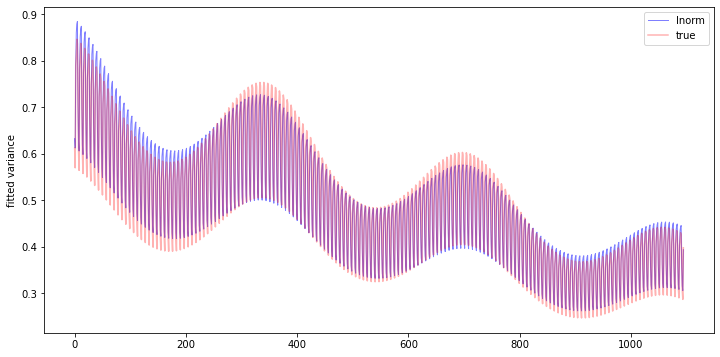

In [1346]:
fittedvar(mod_res).plot(alpha = 0.5, color = "blue", linewidth = 1, label = "lnorm")
plt.plot(data.sigma, alpha = 0.3, color = "red", label = "true")
plt.legend()
plt.ylabel("fitted variance")
plt.show()

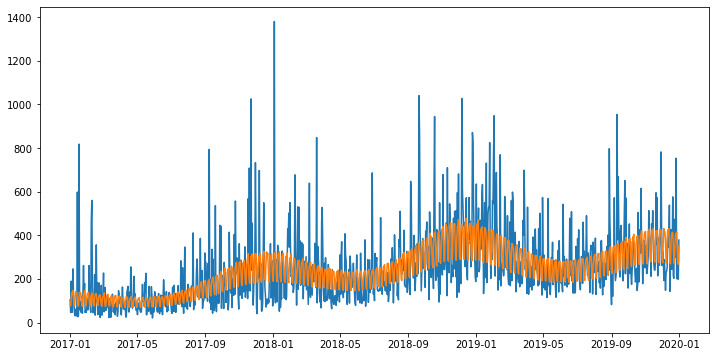

In [1347]:
Y_hat = mod_res.predict(n=1000)
plt.plot(data.days, data.y)
plt.plot(data.days, Y_hat)
plt.show()

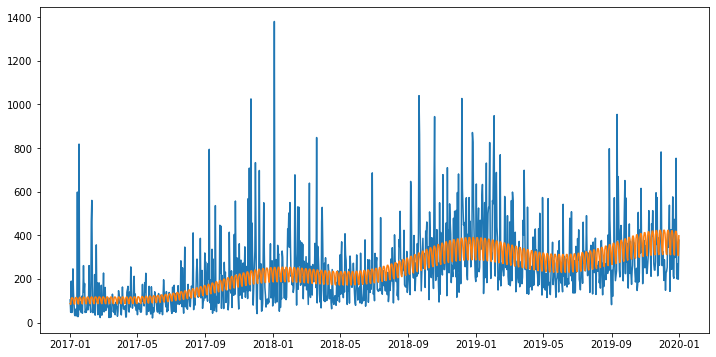

In [1348]:
plt.plot(data.days, data.y)
plt.plot(data.days, gpois_res.predict())
plt.show()

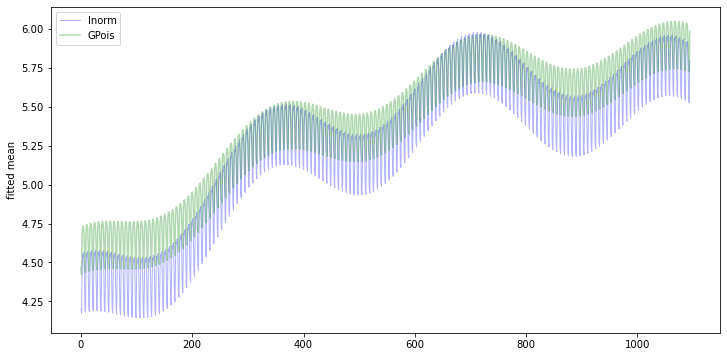

In [1349]:
fittedmean(mod_res).plot(alpha = 0.3, color = "blue", linewidth = 1, label = "lnorm")
gpois_res.fittedvalues.plot(alpha = 0.3, color = "green", label = "GPois")
plt.legend()
plt.ylabel("fitted mean")
plt.show()

In [646]:
# Negative Hessian is PD at optimal values
starting_vals = np.array([ 5., 0.4, -0.17, 0.33, 0.36, 0.4, 0.39, 0.26, 0.07, 0.2, -0.1, -1., -0.2, -0.03, 0.33, 0.36, 0.4, 0.39, 0.26, 0.07, 0.16, -0.05])
starting_vals = np.array([ 5., 0.4, -0.17, 0.33, 0.36, 0.4, 0.39, 0.26, 0.07, 0.2, -0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
np.linalg.eigvals(-mod.hessian(starting_vals))

array([1239.4087817 , 1169.52314199, 1111.64125578,  864.2999525 ,
        672.26134394,  533.12543068,  488.33281412,  379.9177109 ,
        277.77601083,    7.36287098,   21.8011735 ,  220.93999707,
         57.09790965,   68.82226569,   83.88332632,  104.34537605,
        112.89566625,  153.64091058,  161.01953967,  155.23090716,
        158.95178034,  157.82740561])

In [648]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    bs = mod_res.bootstrap(nrep=10, method="ncg", store = 0, disp = 0) # we can bootstrap SE

In [650]:
bs[0] #mean estimates

array([ 5.03815168,  0.39159295, -0.15786661,  0.27307273,  0.28910021,
        0.37668993,  0.433399  ,  0.23910717,  0.04762076,  0.17708231,
       -0.07713208, -1.0740384 , -0.20039225, -0.05841437,  0.27044246,
        0.43196241,  0.46425795,  0.56210821,  0.26103358,  0.11445805,
        0.19101962, -0.09601108])

## Simulation 

In [1352]:
# What else should we test?
N = 50
penalty = 1e-4
sim_params = list()
sim_mse = list()

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for i in range(N):
        data = generate_data()
        
        pois_mdl = sm.Poisson(data.y, data.x_df)
        pois_res = pois_mdl.fit(disp=0)
        sim_params.append(["pois"] + pois_res.params[:11].tolist())
        
        gpois_mdl = sm.GeneralizedPoisson(data.y, data.x_df)
        gpois_res = gpois_mdl.fit(disp=0)
        sim_params.append(["gpois"]+ gpois_res.params[:11].tolist())
        
        NB1_mdl = sm.NegativeBinomialP(data.y, data.x_df,p=1)
        NB1_res = NB1_mdl.fit(disp=0)
        sim_params.append(["NB1"]+ NB1_res.params[:11].tolist())
        
        mod = MyLatentNormal(data.y, data.x_df, extra_params_names=names_alpha)
        start_params = np.zeros(22)
        start_params[:11] = pois_res.params
        mod_res = mod.fit(method = "bfgs", start_params = start_params, maxiter=100, penalty=penalty, disp=0)
        sim_params.append(["lnorm"] + mod_res.params[:11].tolist()) # Just the model coeffecients

        
        sim_mse.append([mse(mod_res, data.y), mse(pois_res, data.y), mse(gpois_res, data.y), mse(NB1_res, data.y)])


In [1353]:
sim_params = pd.DataFrame(sim_params, columns=["model"] + data.x_df.columns.to_list())

In [1354]:
sim_params.groupby(by = "model").mean().T

model,NB1,gpois,lnorm,pois
intercept,5.177172,5.223382,4.999549,5.072190
days_since_start,0.346976,0.355638,0.400498,0.351578
days_since_start_squared,-0.143737,-0.133345,-0.171199,-0.174665
day_of_week_1,0.284852,0.233178,0.323578,0.388957
day_of_week_2,0.317542,0.258068,0.355731,0.438165
day_of_week_3,0.364082,0.296104,0.409257,0.499552
day_of_week_4,0.352200,0.287895,0.391418,0.478562
day_of_week_5,0.230589,0.191452,0.260486,0.312944
day_of_week_6,0.064416,0.055723,0.073240,0.084054
seasonality_cos,0.185112,0.152033,0.201539,0.248665


In [1355]:
#MSE
pd.DataFrame(sim_mse, columns=["lnorm", "pois", "gpois", "NB1"]).mean(axis=0)

lnorm    20764.802105
pois     20669.228658
gpois    21525.177591
NB1      21060.472183
dtype: float64

In [1356]:
N = 10
sim_solver_times = list()
sim_solver_fcalls = list()
penalty = 1e-4

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for i in range(N):
        data = generate_data()
        fcalls = []
        
        # Seed with poisson parameters
        pois_mdl = sm.Poisson(data.y, data.x_df)
        pois_res = pois_mdl.fit(disp=0)
        start_params = np.zeros(22)
        start_params[:11] = pois_res.params
        
        mod = MyLatentNormal(data.y, data.x_df, extra_params_names=names_alpha)
        
        start = timer()
        mod_res = mod.fit(method = "ncg", start_params = start_params, maxiter=100, penalty=penalty, disp=0)
        end = timer()
        ncg = end-start
        fcalls.append(mod_res.mle_retvals["fcalls"])
        
        start = timer()
        mod_res = mod.fit(method = "cg", start_params = start_params, maxiter=100, penalty=penalty, disp=0)
        end = timer()
        cg = end-start
        fcalls.append(mod_res.mle_retvals["fcalls"])
        
        start = timer()
        mod_res = mod.fit(method = "bfgs", start_params = start_params, maxiter=100, penalty=penalty, disp=0)
        end = timer()
        bfgs = end-start
        fcalls.append(mod_res.mle_retvals["fcalls"])
        
        start = timer()
        mod_res = mod.fit(method = "powell", start_params = start_params, maxiter=100, penalty=penalty, disp=0)
        end = timer()
        powell = end-start
        fcalls.append(mod_res.mle_retvals["fcalls"])
        
        sim_solver_times.append([ncg, cg, bfgs, powell])
        sim_solver_fcalls.append(fcalls)

In [1357]:
pd.DataFrame(sim_solver_times, columns=["ncg", "cg", "bfgs", "powell"]).describe()

,ncg,cg,bfgs,powell
count,10.000000,10.000000,10.000000,10.000000
mean,0.153638,0.218611,0.051627,1.117576
std,0.010594,0.024084,0.000674,0.094098
min,0.144702,0.174455,0.050605,1.065888
25%,0.145593,0.217388,0.050969,1.066980
50%,0.150441,0.224266,0.052016,1.072470
75%,0.157672,0.232936,0.052166,1.088904
max,0.178278,0.245227,0.052206,1.298341


In [1358]:
pd.DataFrame(sim_solver_fcalls, columns=["ncg", "cg", "bfgs", "powell"]).describe()

,ncg,cg,bfgs,powell
count,10.000000,10.000000,10.000000,10.000000
mean,14.900000,137.900000,26.600000,1195.500000
std,1.449138,16.360182,0.516398,102.068877
min,13.000000,108.000000,26.000000,1140.000000
25%,14.000000,135.750000,26.000000,1145.250000
50%,15.000000,142.500000,27.000000,1149.500000
75%,15.750000,147.000000,27.000000,1152.500000
max,17.000000,156.000000,27.000000,1392.000000
